In [1]:
from gwsnr import GWSNR
import bilby
from gwsnr.numba import noise_weighted_inner_product, antenna_response_plus, antenna_response_cross

gwsnr = GWSNR(
    waveform_approximant="IMRPhenomXPHM",
    minimum_frequency=20.0,
    sampling_frequency=2048.0,
    snr_type="inner_product",
)

GWSNR: Setting multiprocessing start method to 'fork'.
If you need to use the 'spawn' method (in case error or warning due to other library dependencies),
set the environment variable GWSNR_USE_SPAWN=True *before* running your script.
Command line (single line):
    GWSNR_USE_SPAWN=True python yourscript.py
In a Python script (before importing GWSNR):
    import os
    os.environ['GWSNR_USE_SPAWN'] = 'True'
    import gwsnr


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  9.96
max(mtot) (with the given fmin=20.0): 235.0
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectr

In [18]:
import numpy as np

parameters = {
    "mass_1": 35.2,  # Solar masses
    "mass_2": 28.7,  # Solar masses
    "luminosity_distance": 450.3,  # Mpc
    "theta_jn": 1.24,  # Inclination angle
    "psi": 2.18,  # Polarization angle
    "phase": 4.67,  # Phase
    "geocent_time": 5.43,  # GPS time offset
    "ra": 3.89,  # Right ascension
    "dec": -0.67,  # Declination
    "a_1": 0.73,  # Spin magnitude of primary
    "a_2": 0.41,  # Spin magnitude of secondary
    "tilt_1": 0.98,  # Tilt angle of primary spin
    "tilt_2": 2.14,  # Tilt angle of secondary spin
    "phi_12": 1.76,  # Azimuthal angle between spins
    "phi_jl": 4.12,  # Azimuthal angle between L and J
}

# print('eccentricity', params[17])
# print('frequency_domain_source_model', params[24])

waveform_arguments = dict(
    waveform_approximant="IMRPhenomXPHM",
    reference_frequency=20.0,
    minimum_frequency=20.0,
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=4.0,
    sampling_frequency=2048.0,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
)
polas = waveform_generator.frequency_domain_strain(parameters=parameters)

# h = F+.h+ + Fx.hx
# <h|h> = <h+,h+> + <hx,hx> + 2<h+,hx>
# <h|h> = <h+,h+> + <hx,hx>, if h+ and hx are orthogonal
hp_inner_hp_list = []
hc_inner_hc_list = []
psds_objects = gwsnr.psds_list[0]

# need to compute the inner product for
p_array = psds_objects.get_power_spectral_density_array(waveform_generator.frequency_array)
noise, _ = psds_objects.get_noise_realisation(2048, 4)

idx2 = (p_array.real != 0) & (p_array.real != np.inf)

F_plus = antenna_response_plus(
    ra=parameters["ra"],
    dec=parameters["dec"],
    time=parameters["geocent_time"],
    psi=parameters["psi"],
    detector_tensor=gwsnr.detector_tensor_list[0])
F_cross = antenna_response_cross(
    ra=parameters["ra"],
    dec=parameters["dec"],  
    time=parameters["geocent_time"],
    psi=parameters["psi"],
    detector_tensor=gwsnr.detector_tensor_list[0])

hf = F_plus * polas["plus"][idx2] +  F_cross * polas["cross"][idx2]
mf = noise_weighted_inner_product(
    hf+noise[idx2],
    hf,
    p_array[idx2],
    waveform_generator.duration,
)
np.sqrt(mf)

20:56 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


(22.490983506426687+0.44340552505282016j)

In [16]:
p_array

array([ 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
       -4.95953742e-24-6.42974502e-25j,
        3.63881353e-24-5.08908465e-24j,
        0.00000000e+00+0.00000000e+00j])

In [3]:
F_plus = antenna_response_plus(
    ra=parameters["ra"],
    dec=parameters["dec"],
    time=parameters["geocent_time"],
    psi=parameters["psi"],
    detector_tensor=gwsnr.detector_tensor_list[0])
F_cross = antenna_response_cross(
    ra=parameters["ra"],
    dec=parameters["dec"],  
    time=parameters["geocent_time"],
    psi=parameters["psi"],
    detector_tensor=gwsnr.detector_tensor_list[0])


In [4]:
hf = F_plus * polas["plus"][idx2] +  F_cross * polas["cross"][idx2]
mf = noise_weighted_inner_product(
    hf+p_array[idx2],
    hf,
    p_array[idx2],
    waveform_generator.duration,
)

In [5]:
np.sqrt(mf)

(2.8164012189926784e-11+6.459422976098418e-12j)

In [ ]:
idx2 = (p_array != 0.0) & (p_array != np.inf)

hp_inner_hp = noise_weighted_inner_product(
    polas["plus"][idx2],
    polas["plus"][idx2],
    p_array[idx2],
    waveform_generator.duration,
)

hc_inner_hc = noise_weighted_inner_product(
    polas["cross"][idx2],
    polas["cross"][idx2],
    p_array[idx2],
    waveform_generator.duration,
)

In [7]:
np.sqrt(F_plus**2 * hp_inner_hp + F_cross**2 * hc_inner_hc)

(25.745503144424323+0j)

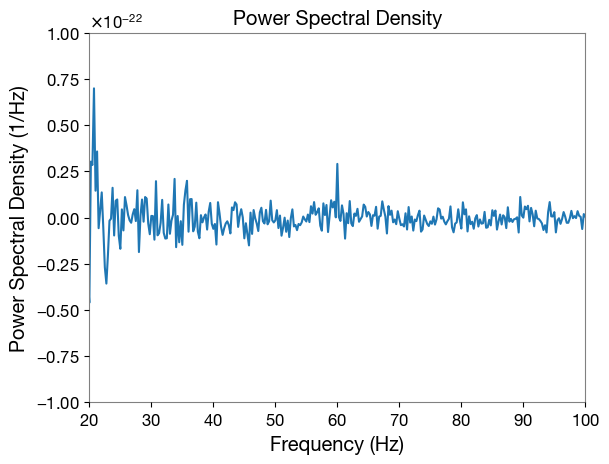

In [64]:
import matplotlib.pyplot as plt

plt.plot(waveform_generator.frequency_array[idx2], p_array[idx2].real)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (1/Hz)")
plt.title("Power Spectral Density")
plt.xlim(20, 100)
plt.ylim(-1e-22, 1e-22)
plt.grid()
plt.show()

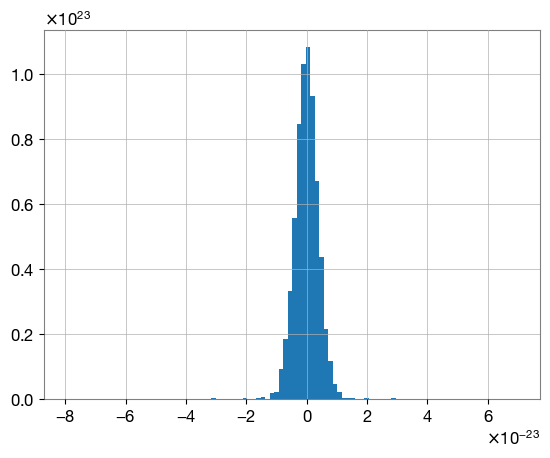

In [66]:
x = p_array[idx2].real
plt.hist(x[abs(x) < 1e-22], bins=100, density=True)
plt.show()

In [67]:
x = p_array[idx2].real
x = x[abs(x) < 1e-22]

# find the mean and standard deviation of x
mean = np.mean(x)
std = np.std(x)
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: -1.2877840697011054e-25
Standard Deviation: 5.015358834962428e-24
